In [1]:
# Imports
import spectral
import numpy as np
from numpy.polynomial import Polynomial
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
import importlib 
import massimal.image_render
import massimal.hyspec_io
# %matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, find_peaks_cwt, medfilt, savgol_filter
import math

import massimal.pipeline

In [2]:
# Paths
calibration_dir = Path('C:\\Users\\mha114\\Dropbox\\UiT\\Massimal\\Eksempel-datasett\\HSI\\20230830_Olberg\\calibration')
radiance_cailbration_file = calibration_dir / 'RadiometricCal100121-278_081220.icp'
downwelling_calibration_file = calibration_dir / 'FLMS16638_Radiometric_Jan2021.dcp'
# raw_image_dir = Path('C:\\Users\\mha114\\Dropbox\\UiT\\Massimal\\Eksempel-datasett\\HSI\\20230830_Olberg\\0_raw')
# raw_image_file = raw_image_dir / 'OlbergholmenS1-5/OlbergholmenS1_Pika_L_5.bil.hdr'
# raw_image_dw_spec_file = raw_image_dir / 'OlbergholmenS1-5/OlbergholmenS1_downwelling_5_pre.spec.hdr'

raw_image_dir = Path('C:\\Users\\mha114\\Dropbox\\UiT\\Massimal\\Eksempel-datasett\\HSI\\20220624_Bodo_Juvika_FlatFieldSand')
raw_image_file = raw_image_dir / 'Juvika_June2022_Pika_L_33-SpatialCrop.bil.hdr'
raw_image_dw_spec_file = raw_image_dir / 'Juvika_June2022_downwelling_33_pre.spec.hdr'



In [3]:
# Read example downwelling spectrum (from the field)
dw_spec,dw_wl,dw_meta = massimal.pipeline.read_envi(raw_image_dw_spec_file)
dw_spec = np.squeeze(dw_spec)

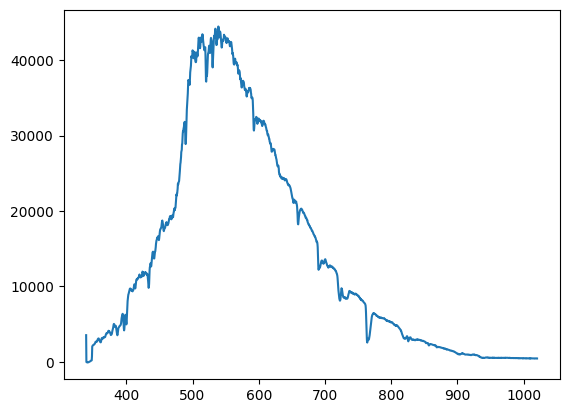

In [4]:
# Plot uncalibrated downwelling spectrum
plt.plot(dw_wl,dw_spec);

In [5]:
importlib.reload(massimal.pipeline);
dirc = massimal.pipeline.IrradianceConverter(downwelling_calibration_file)

INFO: Non-empty downwelling calibration directory C:\Users\mha114\Dropbox\UiT\Massimal\Eksempel-datasett\HSI\20230830_Olberg\calibration\downwelling_calibration_spectra
INFO: Skipping unzipping of downwelling calibration file, assuming unzipping already done.


In [6]:
# Calibrate downwelling spectrum
input_dw_shutter = float(dw_meta['shutter'])
scaled_conv_spec = (dirc._dw_conv_shutter / input_dw_shutter) * dirc._dw_conv_spec

# Subtract dark current, convert to (TODO: check units)
calibrated_dw_spec = (dw_spec - dirc._dw_dark_spec)*scaled_conv_spec

# Limit to valid wavelengths
# valid_wl = self._dw_wl[self._valid_wl_ind]
# calibrated_dw_spec = calibrated_dw_spec[self._valid_wl_ind]

(300.0, 950.0)

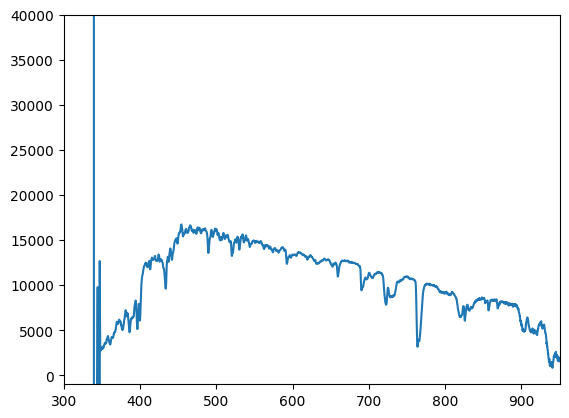

In [7]:
# Plot calibrated downwelling spectrum
plt.plot(dw_wl,calibrated_dw_spec)
plt.ylim((-1000,40000))
plt.xlim((300,950))

Interesting to compare with "Fraunhofer lines": \
![Fraunhofer lines](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Solar_spectral_irradiance.svg/1024px-Solar_spectral_irradiance.svg.png)

In [ ]:
def detect_absorption_peaks(self,spec:np.ndarray,wl:np.ndarray,
                            distance:int=20,width:int=5,
                            rel_prominence:float=0.1):
    """ Detect absorption peaks/lines using local peak detection """
    wl_550_ind = massimal.pipeline.closest_wl_index(wl,550)
    prominence = spec[wl_550_ind]*rel_prominence
    peak_indices, peak_properties = find_peaks(-spec, distance=distance,width=width,
                            prominence=prominence)
    return peak_indices, peak_properties

In [8]:
# Get peak spectrum and detect peaks
peak_spec = dirc.get_absorption_peak_spectrum(calibrated_dw_spec)
peaks_ind, peak_properties = dirc.detect_absorption_peaks(calibrated_dw_spec,dw_wl)


wl_550_ind=570
prominence=1489.6530273437502
np.min(peak_spec)=-11301940.0, np.max(peak_spec)=327220.88


In [9]:
print(peaks_ind)
print(dw_wl[peaks_ind])
print(peak_properties['widths'])

[  57   99  124  151  250  273  402  488  691  884  976 1073 1199 1393
 1493 1702 1770 1908 1978]
[ 361.085  377.033  386.485  396.66   433.667  442.196  489.559  520.683
  592.705  659.284  690.365  722.673  763.93   825.871  857.044  920.526
  940.69   980.866 1000.862]
[23.52837315 11.54583007 10.76086852  5.31802953  8.97505723  8.70321551
  7.35869702  9.81469833 10.13551101  7.95855208 13.8921839  11.7031859
 29.34395351  5.94030261  7.56486288 40.69892352 24.4008991   7.13675381
  7.43048661]


(-3000.0, 15000.0)

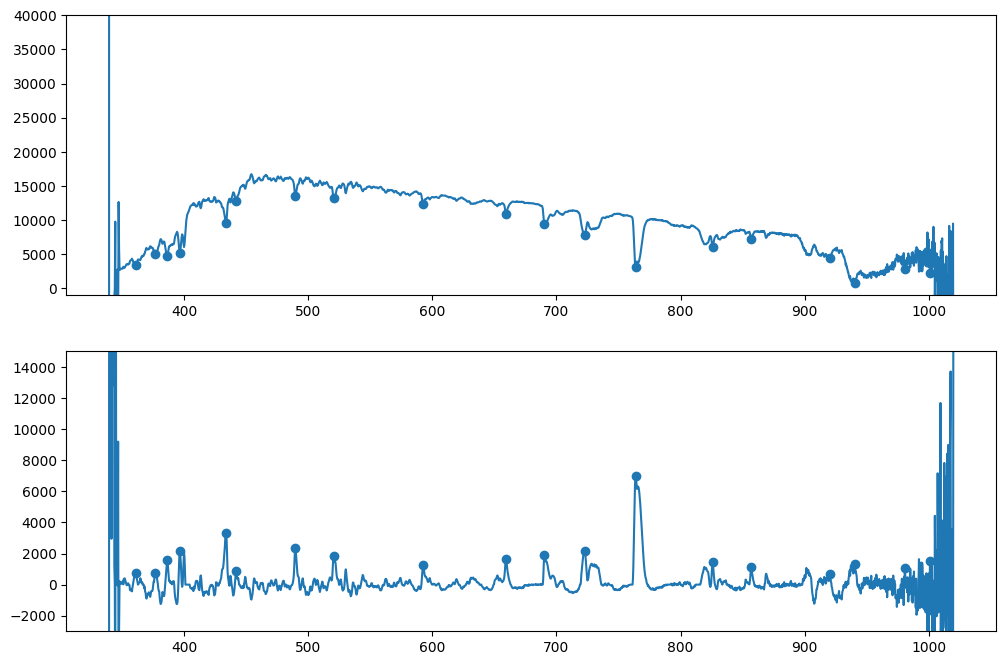

In [10]:
# Plot spectrum with detected peaks
# %matplotlib widget
fig,ax = plt.subplots(nrows=2,figsize=(12,8))
ax[0].plot(dw_wl,calibrated_dw_spec)
ax[0].scatter(dw_wl[peaks_ind],calibrated_dw_spec[peaks_ind])
ax[0].set_ylim((-1000,40000))
ax[1].plot(dw_wl,peak_spec)
ax[1].scatter(dw_wl[peaks_ind],peak_spec[peaks_ind])
ax[1].set_ylim((-3000,15000))


In [11]:
print(dw_wl[peaks_ind])

[ 361.085  377.033  386.485  396.66   433.667  442.196  489.559  520.683
  592.705  659.284  690.365  722.673  763.93   825.871  857.044  920.526
  940.69   980.866 1000.862]


- 430.78 nm (G)
- 486.13 nm (F)
- 518.36 nm (b1)
- 588.99 nm (D1) + 589.59 (D2) = approx 589.30 nm 
- 656.28 nm (C)
- 686.72 nm (B)
- 759.37 nm (A)

In [12]:
# Define search window for each peak
fraunhofer_wls = {'L':382.04,
                  'G':430.78,
                  'F':486.13,
                  'b1':518.36,
                  'D':589.30,
                  'C':656.28,
                  'B':686.72,
                  'A':760.30,
                  'Z':822.70}
wl_win_width = 20
n_wl = len(dw_wl)

# NOTE: Central wavelength for band A changed from 759.37 to 760.30
# This absorption line is really a band, and the absorption peak is
# less defined than for other lines. The new value seems better fitting 
# for the spectral resolution of the irradiance.

# fh_wl_ind = [massimal.pipeline.closest_wl_index(dw_wl,fr_wl) for fr_wl in fraunhofer_wls.values()]
# win_half_width_samples = [round((0.5*wl_win_width)/(dw_wl[ind+1]-dw_wl[ind])) 
#                             for ind in fh_wl_ind]
# wl_wins = [(max(ind-width,0),min(ind+width,n_wl-1))  
#             for ind,width in zip(fh_wl_ind, win_half_width_samples)]

#fraunhofer_samples = {key:None for key in fraunhofer_wls}
fh_sample_x = []
fh_wl_y = []
for (fh_line_name, fh_line_wl) in fraunhofer_wls.items():
    # Find index of closest sample to Fraunhofer wavelength
    fh_wl_ind = massimal.pipeline.closest_wl_index(dw_wl,fh_line_wl)
    # Calculate half window width in samples at current wavelength
    win_half_width = round((0.5*wl_win_width)/(dw_wl[fh_wl_ind+1]-dw_wl[fh_wl_ind]))
    # Calculate edges of search window
    win_low = fh_wl_ind - win_half_width
    win_high = fh_wl_ind + win_half_width
    # Find peaks within search window
    peaks_in_window = peaks_ind[(peaks_ind>=win_low) & (peaks_ind<=win_high)]
    if len(peaks_in_window)==1:
        # fraunhofer_samples[fh_line_name] = peaks_in_window[0]
        fh_sample_x.append(peaks_in_window[0])
        fh_wl_y.append(fh_line_wl)
    
# print(fraunhofer_samples)


In [13]:
print(fh_sample_x)
print(fh_wl_y)

# wl_poly_coeff = np.polyfit(fh_sample_x,fh_wl_y,deg=2)
# wl_poly_coeff, residuals, rank, singular_values, rcond = np.polyfit(fh_sample_x,fh_wl_y,deg=2,full=True)
# polynomial = np.polynomial.Polynomial()
# wl_poly_coeff, wl_poly_meta  = Polynomial.polyfit(fh_sample_x,fh_wl_y,deg=2,full=True)
polynomial_fitted = Polynomial.fit(fh_sample_x,fh_wl_y,deg=2,domain=[])
print(polynomial_fitted)
print(polynomial_fitted.coef)
# polynomial = np.polynomial.Polynomial(wl_poly_coeff)
# print(f'{polynomial=}')
# residuals, rank, singular_values, rcond = wl_poly_meta
# print(f'{wl_poly_coeff=}')
# print(f'{residuals=}')

[250, 402, 488, 691, 884, 976, 1199, 1393]
[430.78, 486.13, 518.36, 589.3, 656.28, 686.72, 760.3, 822.7]
336.66850382 + 0.38273824 x - (2.43765735e-05) x**2
[ 3.36668504e+02  3.82738244e-01 -2.43765735e-05]


In [14]:
n = np.arange(len(dw_wl))
# wl_cal = np.polyval(wl_poly_coeff,n)
wl_cal = polynomial_fitted(n)
for wl_orig_i, wl_cal_i in zip(dw_wl, wl_cal):
    print(f'{wl_orig_i} -> {wl_cal_i}, diff. {wl_cal_i-wl_orig_i}')

339.306 -> 336.66850382206013, diff. -2.637496177939852
339.689 -> 337.05121768921106, diff. -2.637782310788964
340.072 -> 337.4338828032149, diff. -2.6381171967851174
340.456 -> 337.8164991640716, diff. -2.639500835928402
340.839 -> 338.1990667717813, diff. -2.6399332282186947
341.222 -> 338.5815856263439, diff. -2.6404143736560854
341.606 -> 338.9640557277594, diff. -2.6419442722406075
341.989 -> 339.34647707602784, diff. -2.6425229239721375
342.372 -> 339.7288496711492, diff. -2.6431503288508225
342.755 -> 340.11117351312345, diff. -2.6438264868765486
343.138 -> 340.4934486019506, diff. -2.644551398049373
343.521 -> 340.8756749376307, diff. -2.645325062369295
343.904 -> 341.25785252016374, diff. -2.6461474798362588
344.287 -> 341.63998134954966, diff. -2.6470186504503204
344.669 -> 342.0220614257885, diff. -2.6469385742115037
345.052 -> 342.40409274888026, diff. -2.6479072511197614
345.435 -> 342.78607531882494, diff. -2.6489246811750604
345.817 -> 343.1680091356226, diff. -2.648990

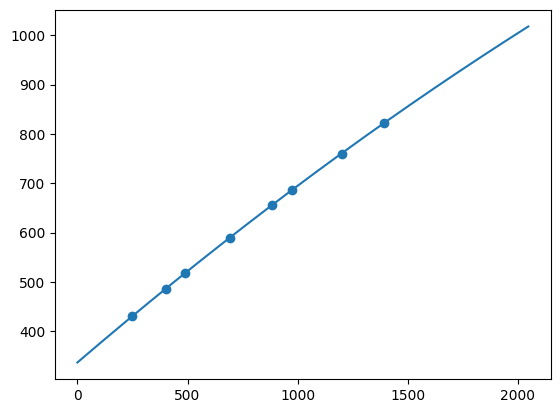

In [15]:
# %matplotlib widget
fig = plt.figure()
plt.plot(n,wl_cal);
plt.scatter(fh_sample_x,fh_wl_y)

In [16]:
for i,fh_s in enumerate(fh_sample_x):
    print(f'True WL: {fh_wl_y[i]}, fitted WL: {wl_cal[fh_s]}')


True WL: 430.78, fitted WL: 430.82952890686687
True WL: 486.13, fitted WL: 486.58992600878497
True WL: 518.36, fitted WL: 517.6396320302663
True WL: 589.3, fitted WL: 589.5012795247678
True WL: 656.28, fitted WL: 655.9598916214869
True WL: 686.72, fitted WL: 687.0004907798148
True WL: 760.3, fitted WL: 760.527871548684
True WL: 822.7, fitted WL: 822.521379579324


(-1000.0, 40000.0)

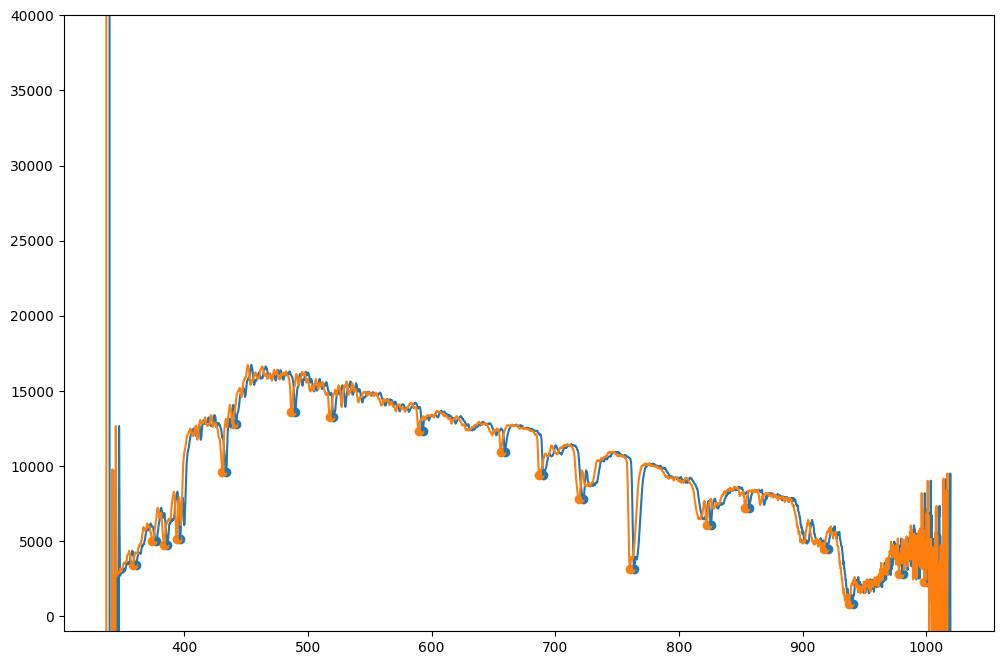

In [17]:
# Plot spectrum with non-calibrated and calibrated wavelengths
# %matplotlib widget
fig,ax = plt.subplots(nrows=1,figsize=(12,8))
ax.plot(dw_wl,calibrated_dw_spec)
ax.scatter(dw_wl[peaks_ind],calibrated_dw_spec[peaks_ind])
ax.plot(wl_cal,calibrated_dw_spec)
ax.scatter(wl_cal[peaks_ind],calibrated_dw_spec[peaks_ind])
ax.set_ylim((-1000,40000))


In [36]:
gaussian_fwhm = 3.7
sigma_wl = gaussian_fwhm*0.588705  # sigma = FWHM / 2*sqrt(2*ln(2))
dw_dwl = np.mean(np.diff(wl_cal))   # Downwelling wavelength sampling dist.
sigma_pix = sigma_wl / dw_dwl      # Sigma in units of spectral samples 
dw_spec_gauss_filt = gaussian_filter1d(input=calibrated_dw_spec,sigma=sigma_pix,mode='nearest')

(-1000.0, 40000.0)

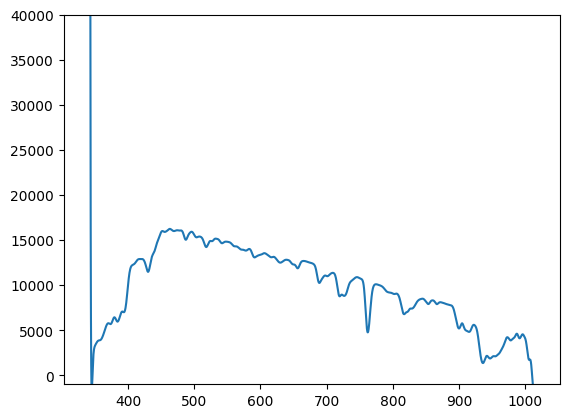

In [37]:
fig = plt.figure()
plt.plot(wl_cal,dw_spec_gauss_filt)
plt.ylim((-1000,40000))

In [38]:
hsi_im, hsi_wl, hsi_meta = massimal.pipeline.read_envi(raw_image_file)

In [39]:
for i,wl in enumerate(hsi_wl):
    print(f'{i}: {wl}')

0: 390.86
1: 392.87
2: 394.88
3: 396.89
4: 398.9
5: 400.91
6: 402.92
7: 404.93
8: 406.94
9: 408.96
10: 410.97
11: 412.99
12: 415.0
13: 417.02
14: 419.04
15: 421.06
16: 423.08
17: 425.1
18: 427.12
19: 429.14
20: 431.17
21: 433.19
22: 435.22
23: 437.24
24: 439.27
25: 441.3
26: 443.33
27: 445.36
28: 447.39
29: 449.42
30: 451.45
31: 453.49
32: 455.52
33: 457.56
34: 459.59
35: 461.63
36: 463.67
37: 465.71
38: 467.75
39: 469.79
40: 471.83
41: 473.87
42: 475.91
43: 477.96
44: 480.0
45: 482.05
46: 484.1
47: 486.14
48: 488.19
49: 490.24
50: 492.29
51: 494.34
52: 496.39
53: 498.45
54: 500.5
55: 502.56
56: 504.61
57: 506.67
58: 508.73
59: 510.79
60: 512.84
61: 514.9
62: 516.97
63: 519.03
64: 521.09
65: 523.15
66: 525.22
67: 527.29
68: 529.35
69: 531.42
70: 533.49
71: 535.56
72: 537.63
73: 539.7
74: 541.77
75: 543.84
76: 545.92
77: 547.99
78: 550.07
79: 552.14
80: 554.22
81: 556.3
82: 558.38
83: 560.46
84: 562.54
85: 564.62
86: 566.7
87: 568.78
88: 570.87
89: 572.95
90: 575.04
91: 577.13
92: 579.2

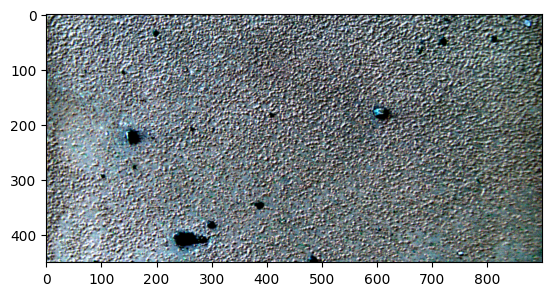

In [40]:
fig = plt.figure()
rgb_ind = (30,78,126)
plt.imshow(massimal.image_render.percentile_stretch(hsi_im[:,:,rgb_ind]))

(-0.1, 1.3)

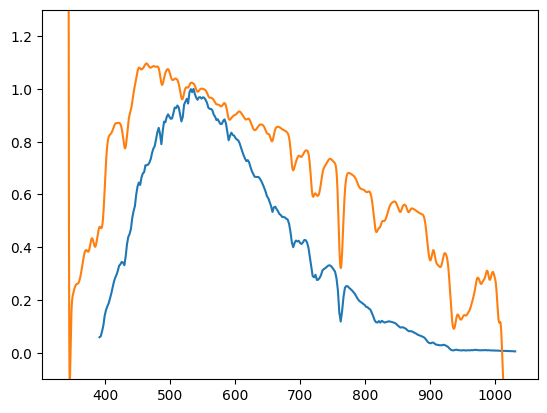

In [44]:
example_spec = np.mean(hsi_im[50:150,445:455,:], axis=(0,1))
example_spec /= np.max(example_spec)

dw_spec_norm = dw_spec_gauss_filt / dw_spec_gauss_filt[
    massimal.pipeline.closest_wl_index(wl_cal,550)
]

fig = plt.figure()
plt.plot(hsi_wl,example_spec)
plt.plot(wl_cal,dw_spec_norm)
plt.ylim((-0.1,1.3))

In [42]:
dw_spec_im_wls_calibrated = np.interp(hsi_wl,wl_cal,dw_spec_norm)
dw_spec_im_wls_uncalibrated = np.interp(hsi_wl,dw_wl,dw_spec_norm)


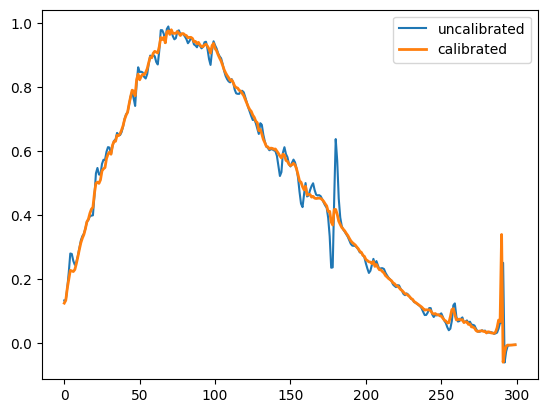

In [46]:
plt.figure()
plt.plot(example_spec/dw_spec_im_wls_uncalibrated,label='uncalibrated')
plt.plot(example_spec/dw_spec_im_wls_calibrated,linewidth=2,label='calibrated')
plt.legend()

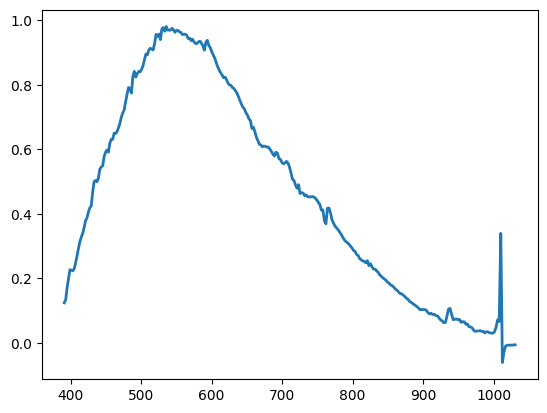

In [48]:
plt.figure()
plt.plot(hsi_wl,example_spec/dw_spec_im_wls_calibrated,linewidth=2,label='calibrated')

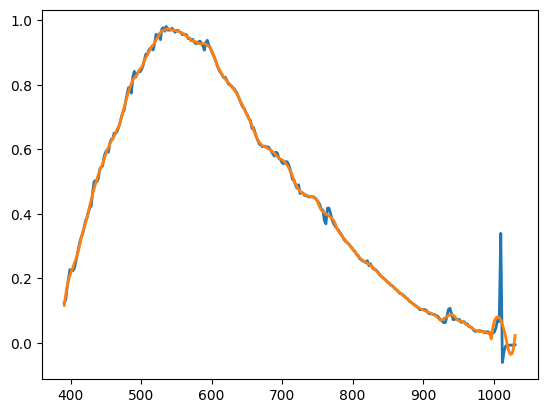

In [53]:
dummy_reflectance = example_spec/dw_spec_im_wls_calibrated
dummy_reflectance_sgfilt = savgol_filter(dummy_reflectance,13,3)
plt.figure()
plt.plot(hsi_wl,dummy_reflectance,linewidth=2)
plt.plot(hsi_wl,dummy_reflectance_sgfilt,linewidth=2)